# Figure: Output to the oviIN prominence 
1. Connect to neuprint and imports
2. Pull simple connections of the oviINr
3. Filter dataframe for each celltype to find where the oviIN type ranks with each celltype's outputs
4. Plot counts  

This file was written by Rhessa Weber Langstaff based on the hub_spoke_sandbox.ipynb file in the Gutierrez lab github.

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from neuprint import Client
import matplotlib.patheffects as path_effects

from neuprint import fetch_simple_connections, fetch_neurons, NeuronCriteria as NC


auth_token_file = open("flybrain.auth.txt", 'r')
auth_token = next(auth_token_file).strip()
try:
    np_client = Client('neuprint.janelia.org', dataset='hemibrain:' + 'v1.2.1', token=auth_token)
except:
    np_client = None



Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.
Intel MKL WARNING: Support of Intel(R) Streaming SIMD Extensions 4.2 (Intel(R) SSE4.2) enabled only processors has been deprecated. Intel oneAPI Math Kernel Library 2025.0 will require Intel(R) Advanced Vector Extensions (Intel(R) AVX) instructions.


In [2]:
# Body Ids of oviINs
oviINr= 423101189
oviINl= 485934965

In [3]:
# inputs to the oviINr
ovi_inputs = fetch_simple_connections(None, oviINr)
ovi_inputs

,bodyId_pre,bodyId_post,weight,type_pre,type_post,instance_pre,instance_post,conn_roiInfo
0,611015907,423101189,287,SMP176,oviIN,SMP176_R,oviIN_R,"{'INP': {'pre': 54, 'post': 53}, 'CRE(R)': {'p..."
1,5813087891,423101189,255,SMP544,oviIN,SMP544_R,oviIN_R,"{'LX(R)': {'pre': 66, 'post': 65}, 'LAL(R)': {..."
2,1598011458,423101189,243,LAL134,oviIN,LAL134_R,oviIN_R,"{'LX(R)': {'pre': 42, 'post': 42}, 'LAL(R)': {..."
3,5813022375,423101189,236,IB017,oviIN,IB017_R,oviIN_R,"{'SNP(R)': {'pre': 97, 'post': 97}, 'SMP(R)': ..."
4,448342846,423101189,225,CRE075,oviIN,CRE075_R,oviIN_R,"{'INP': {'pre': 199, 'post': 199}, 'CRE(R)': {..."
...,...,...,...,...,...,...,...,...
2519,5901221890,423101189,1,SLP422,oviIN,SLP422_R,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
2520,5901226036,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'..."
2521,5901230025,423101189,1,None,oviIN,None,oviIN_R,"{'VMNP': {'pre': 1, 'post': 1}, 'VES(R)': {'pr..."
2522,5901231318,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(L)': {'pre': 1, 'post': 1}, 'SMP(L)': {'..."


In [4]:
# import modularity data
mod = pd.read_csv('oviIN/preprocessed_inputs-v1.2.1/preprocessed_nodes.csv', index_col=0)
mod

,key,0.0,0.05,0.1,0.5,0.75,1.0,instance,celltype,pre,...,status,cropped,statusLabel,cellBodyFiber,somaRadius,somaLocation,roiInfo,notes,inputRois,outputRois
id,,,,,,,,,,,,,,,,,,,,,
1003215282,1,1,1,1,1,1,1,CL229_R,CL229,100,...,Traced,False,Roughly traced,PDM19,301.0,"[23044, 14981, 11600]","{'INP': {'pre': 87, 'post': 351, 'downstream':...",NaN,"['EPA(R)', 'GOR(R)', 'IB', 'ICL(R)', 'INP', 'S...","['GOR(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
1005952640,2,2,1,1,2,2,2,IB058_R,IB058,664,...,Traced,False,Roughly traced,PVL20,NaN,NaN,"{'INP': {'pre': 464, 'post': 1327, 'downstream...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S..."
1006928515,3,1,1,1,3,3,3,CL300_R,CL300,86,...,Traced,False,Roughly traced,PVL13,236.0,"[12083, 10523, 16816]","{'INP': {'pre': 79, 'post': 126, 'downstream':...",NaN,"['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S...","['ATL(R)', 'IB', 'ICL(R)', 'INP', 'SCL(R)', 'S..."
1007260806,4,2,1,1,4,4,4,CL301_R,CL301,119,...,Traced,False,Roughly traced,PVL13,236.0,"[13524, 10108, 16480]","{'INP': {'pre': 40, 'post': 128, 'downstream':...",NaN,"['GOR(R)', 'IB', 'ICL(R)', 'INP', 'PLP(R)', 'S...","['IB', 'ICL(R)', 'INP', 'PLP(R)', 'SCL(R)', 'S..."
1008024276,5,3,2,2,5,5,5,FB5N_R,FB5N,499,...,Traced,False,Roughly traced,AVM08,472.5,"[19178, 29711, 37312]","{'SNP(L)': {'post': 5, 'upstream': 5, 'mito': ...",SMPCREFB5_4,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
987273073,2507,3,8,8,409,604,629,(PVL05)_L,NaN,283,...,Traced,False,Roughly traced,NaN,NaN,NaN,"{'SNP(R)': {'pre': 65, 'post': 52, 'downstream...",NaN,"['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'...","['CRE(-ROB,-RUB)(R)', 'CRE(-RUB)(L)', 'CRE(L)'..."
987842109,2508,3,9,23,533,780,815,NaN,NaN,2,...,Orphan,NaN,Orphan hotknife,NaN,NaN,NaN,"{'SNP(R)': {'pre': 2, 'post': 13, 'downstream'...",NaN,"['SMP(R)', 'SNP(R)']","['SMP(R)', 'SNP(R)']"
988567837,2509,2,3,4,16,58,63,FB4G_R,FB4G,785,...,Traced,False,Roughly traced,AVM08,NaN,NaN,"{'SNP(R)': {'pre': 6, 'post': 73, 'downstream'...",CRELALFB4_3,"['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F...","['CRE(-ROB,-RUB)(R)', 'CRE(R)', 'CX', 'FB', 'F..."


In [5]:
# drop everything but the modularity data
mod = mod[['0.0', '0.05', '0.1', '0.5', '0.75', '1.0', 'celltype']]
mod


,0.0,0.05,0.1,0.5,0.75,1.0,celltype
id,,,,,,,
1003215282,1,1,1,1,1,1,CL229
1005952640,2,1,1,2,2,2,IB058
1006928515,1,1,1,3,3,3,CL300
1007260806,2,1,1,4,4,4,CL301
1008024276,3,2,2,5,5,5,FB5N
...,...,...,...,...,...,...,...
987273073,3,8,8,409,604,629,NaN
987842109,3,9,23,533,780,815,NaN
988567837,2,3,4,16,58,63,FB4G


In [6]:
# cross merge on the bodyids presynaptic
ovi_inputs = ovi_inputs.merge(mod, left_on='bodyId_pre', right_on = mod.index, how='left')
ovi_inputs

,bodyId_pre,bodyId_post,weight,type_pre,type_post,instance_pre,instance_post,conn_roiInfo,0.0,0.05,0.1,0.5,0.75,1.0,celltype
0,611015907,423101189,287,SMP176,oviIN,SMP176_R,oviIN_R,"{'INP': {'pre': 54, 'post': 53}, 'CRE(R)': {'p...",1.0,13.0,15.0,262.0,337.0,446.0,SMP176
1,5813087891,423101189,255,SMP544,oviIN,SMP544_R,oviIN_R,"{'LX(R)': {'pre': 66, 'post': 65}, 'LAL(R)': {...",2.0,7.0,7.0,156.0,139.0,151.0,SMP544
2,1598011458,423101189,243,LAL134,oviIN,LAL134_R,oviIN_R,"{'LX(R)': {'pre': 42, 'post': 42}, 'LAL(R)': {...",2.0,7.0,7.0,36.0,184.0,118.0,LAL134
3,5813022375,423101189,236,IB017,oviIN,IB017_R,oviIN_R,"{'SNP(R)': {'pre': 97, 'post': 97}, 'SMP(R)': ...",2.0,3.0,4.0,331.0,448.0,563.0,IB017
4,448342846,423101189,225,CRE075,oviIN,CRE075_R,oviIN_R,"{'INP': {'pre': 199, 'post': 199}, 'CRE(R)': {...",2.0,3.0,4.0,305.0,415.0,382.0,CRE075
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2519,5901221890,423101189,1,SLP422,oviIN,SLP422_R,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'...",5.0,5.0,20.0,240.0,318.0,273.0,SLP422
2520,5901226036,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(R)': {'pre': 1, 'post': 1}, 'SMP(R)': {'...",1.0,10.0,5.0,405.0,599.0,622.0,NaN
2521,5901230025,423101189,1,None,oviIN,None,oviIN_R,"{'VMNP': {'pre': 1, 'post': 1}, 'VES(R)': {'pr...",2.0,60.0,57.0,227.0,287.0,249.0,NaN
2522,5901231318,423101189,1,None,oviIN,None,oviIN_R,"{'SNP(L)': {'pre': 1, 'post': 1}, 'SMP(L)': {'...",4.0,15.0,11.0,406.0,600.0,623.0,NaN


In [7]:
# Only use neccessary columns and collapse by celltype in ascending order and the number in column '0.0
ovi_inputs_new = ovi_inputs[['type_pre', 'weight']].groupby('type_pre',as_index=False).sum().sort_values(by='weight', ascending=False, ignore_index=True)

In [8]:
# Filter out the cells with less than 100 synapses
ovi_inputs_col = ovi_inputs_new[ovi_inputs_new['weight'] >= 100]
ovi_inputs_col

,type_pre,weight
0,FS1A,892
1,IB017,370
2,SMP052,361
3,SMP176,299
4,FC2B,290
5,SMP383,281
6,SMP544,259
7,LAL134,247
8,SMP550,234
9,CRE075,225


In [9]:
# merge the 0.0 modularity data onto the ovi_inputs
ovi_inputs_merged = ovi_inputs_col.merge(mod, left_on='type_pre', right_on = 'celltype', how='left')
ovi_inputs_merged

,type_pre,weight,0.0,0.05,0.1,0.5,0.75,1.0,celltype
0,FS1A,892,3,2,2,5,5,20,FS1A
1,FS1A,892,3,2,2,5,5,20,FS1A
2,FS1A,892,3,2,2,5,5,20,FS1A
3,FS1A,892,3,2,2,5,5,10,FS1A
4,FS1A,892,3,2,2,5,5,23,FS1A
...,...,...,...,...,...,...,...,...,...
140,SMP175,103,5,5,20,249,339,368,SMP175
141,SMP556,102,2,1,6,178,515,515,SMP556
142,SMP556,102,2,3,4,106,500,601,SMP556
143,SMP311,102,4,15,11,276,443,462,SMP311


In [10]:
# drop all the columns that are not needed
ovi_inputs_filtered = ovi_inputs_merged[['type_pre', 'weight', '0.0']]
ovi_inputs_filtered

,type_pre,weight,0.0
0,FS1A,892,3
1,FS1A,892,3
2,FS1A,892,3
3,FS1A,892,3
4,FS1A,892,3
...,...,...,...
140,SMP175,103,5
141,SMP556,102,2
142,SMP556,102,2
143,SMP311,102,4


In [11]:
# Collapse the data by type pre without summing weights
ovi_inputs_grouped = ovi_inputs_filtered.groupby('type_pre', as_index=False).first()

# Order by module in 0.0 column
ovi_inputs_final = ovi_inputs_grouped.sort_values(by='0.0', ascending=True, ignore_index=True)
ovi_inputs_final

,type_pre,weight,0.0
0,SMP176,299,1
1,SMP566,203,1
2,SMP520,125,1
3,SMP383,281,1
4,SMP314,106,1
5,SMP237,163,1
6,SMP051,157,1
7,VES047,118,2
8,SMP556,102,2
9,CRE075,225,2


In [14]:
ovi_inputs_use = ovi_inputs_final.copy()

In [15]:
# Process to fetch connections for each celltype and find out where oviIN ranks in each celltype's outputs
testchunk = ovi_inputs_use.copy()  # Copies dataframe to avoid SettingWithCopyWarning

# Add columns to testchunk
testchunk['out_to_ovis_weight'] = 0
testchunk['out_to_ovis_rank'] = 0

# iterate through each row in testchunk and fetch connections for each cell type in order to find out where oviIN ranks with each cell's outputs
for idx, row in testchunk.iterrows():
    # fetch outputs for each top input of oviIN
    i_outputs = fetch_simple_connections(row.type_pre,None)

    # grab only necessary columns
    i_outputs = i_outputs[['type_post','weight']]

    # collapse outputs by cell type, summing along weights, and sort in descending order
    i_outputs = i_outputs.groupby('type_post', as_index=False).sum().sort_values(by='weight', ascending=False,ignore_index=True)

    # grab the row where oviIN is. there will be 1 row for both oviINr and oviINl.
    thing = i_outputs[i_outputs['type_post'] == 'oviIN'].weight

    # add the weight and rank of oviIN in its partners outputs to the testchunk dataframe
    testchunk.loc[idx,'out_to_ovis_weight'] = thing.values[0]
    testchunk.loc[idx,'out_to_ovis_rank'] = thing.index.values[0]


In [16]:
testchunk_edit = testchunk.sort_values(by='out_to_ovis_weight', ascending=False, ignore_index=True)
# Testchunk drop columns
testchunk_small = testchunk_edit[['type_pre', 'out_to_ovis_rank']]
# Pivot so that celltypes in the index, and oviIN ranks in the columns
testchunk_pivot = testchunk_small.pivot(index='out_to_ovis_rank', columns='type_pre', values='out_to_ovis_rank')

# Replace any non-Nan values with the number 1
testchunk_pivot = testchunk_pivot.notnull().astype('int')

# replace any zeros with NaN
testchunk_pivot = testchunk_pivot.replace(0, np.nan)

# Add in a blank row after 7 for plotting purposes
testchunk_pivot.loc[10]= np.nan

# Sort the index
testchunk_pivot = testchunk_pivot.sort_index(ascending=True)

testchunk_pivot

type_pre,CRE075,CRE077,FC2B,FC2C,FS1A,IB017,LAL022,LAL134,OA-VUMa7,SMP007,...,SMP386,SMP520,SMP544,SMP550,SMP551,SMP556,SMP566,VES047,pC1d,pC1e
out_to_ovis_rank,,,,,,,,,,,,,,,,,,,,,
0,NaN,NaN,NaN,NaN,1.0,1.0,NaN,1.0,NaN,1.0,...,1.0,1.0,1.0,1.0,1.0,NaN,1.0,1.0,NaN,1.0
1,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
3,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN
4,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
5,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
6,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,1.0,NaN,NaN,NaN,NaN
7,NaN,NaN,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [18]:
import math
# function creates distint colors for each cell type
# Found this on stackoverflow: https://stackoverflow.com/questions/42697933/colormap-with-maximum-distinguishable-colours
def generate_colormap(N):
    arr = np.arange(N)/N
    N_up = int(math.ceil(N/7)*7)
    arr.resize(N_up)
    arr = arr.reshape(7,N_up//7).T.reshape(-1)
    ret = plt.cm.gist_rainbow(arr)
    n = ret[:,3].size
    a = n//2
    b = n-a
    for i in range(3):
        ret[0:n//2,i] *= np.arange(0.2,1,0.8/a)
    ret[n//2:,3] *= np.arange(1,0.1,-0.9/b)
#     print(ret)
    return ret

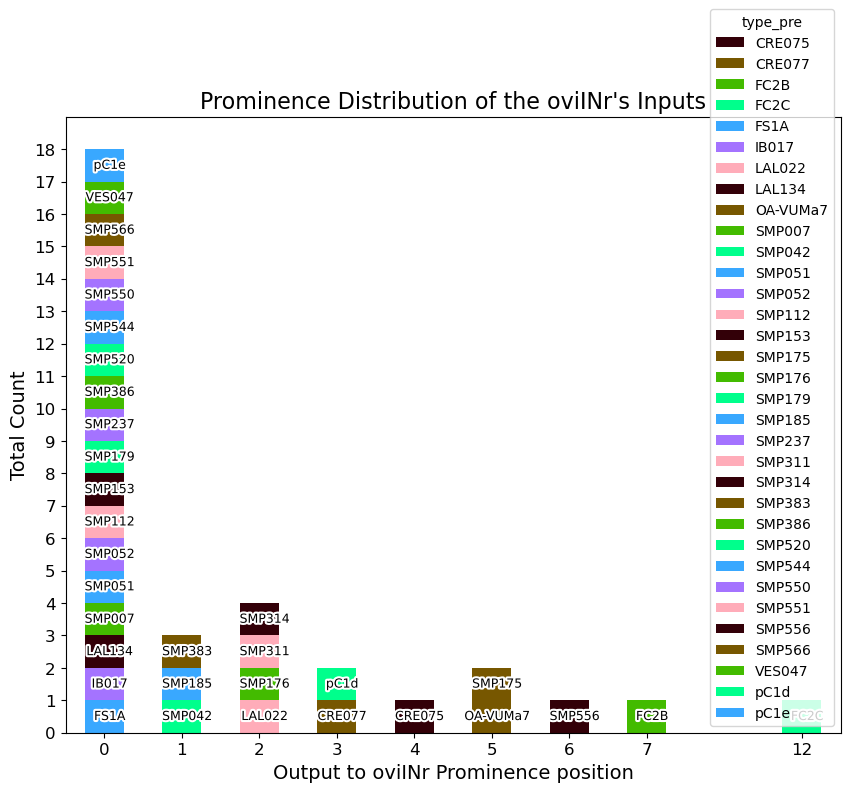

In [19]:
# Plotting the data
fig, ax = plt.subplots(figsize=(10, 8))
# stacked bar plot
testchunk_pivot.plot(kind='bar', stacked=True, ax=ax, color= generate_colormap(len(ovi_inputs['0.0'].unique())))

# generate labels for each stacked bar using the cell type names
labels = testchunk_pivot.columns

# annotate the stacked bar plot
for i in range(len(testchunk_pivot)):
    y = 0
    for j in range(len(testchunk_pivot.columns)):
        if testchunk_pivot.iloc[i,j] == 1:
            # annotate with black font and white outline
            ax.text(i+0.07, y + 0.5, labels[j], ha='center', va='center', rotation=0, fontsize=9, color='black', path_effects=[path_effects.withStroke(linewidth=3, foreground='white')])
            y += 1

# legend should outside the plot and only the group colors 
ax.get_legend()

plt.xticks(rotation=0,fontsize=12)
ax.set_yticks(np.linspace(0, 18, 19))
ax.set_yticklabels(np.linspace(0, 18, 19, dtype=int), fontsize=12)
ax.set_ylabel('Total Count', fontsize=14)
ax.set_xlabel('Output to oviINr Prominence position', fontsize=14)
ax.set_title("Prominence Distribution of the oviINr's Inputs", fontsize=16)
plt.ylim(0, 19)
xticks = ax.xaxis.get_major_ticks()
xticks[8].set_visible(False)



(0.0, 20.0)

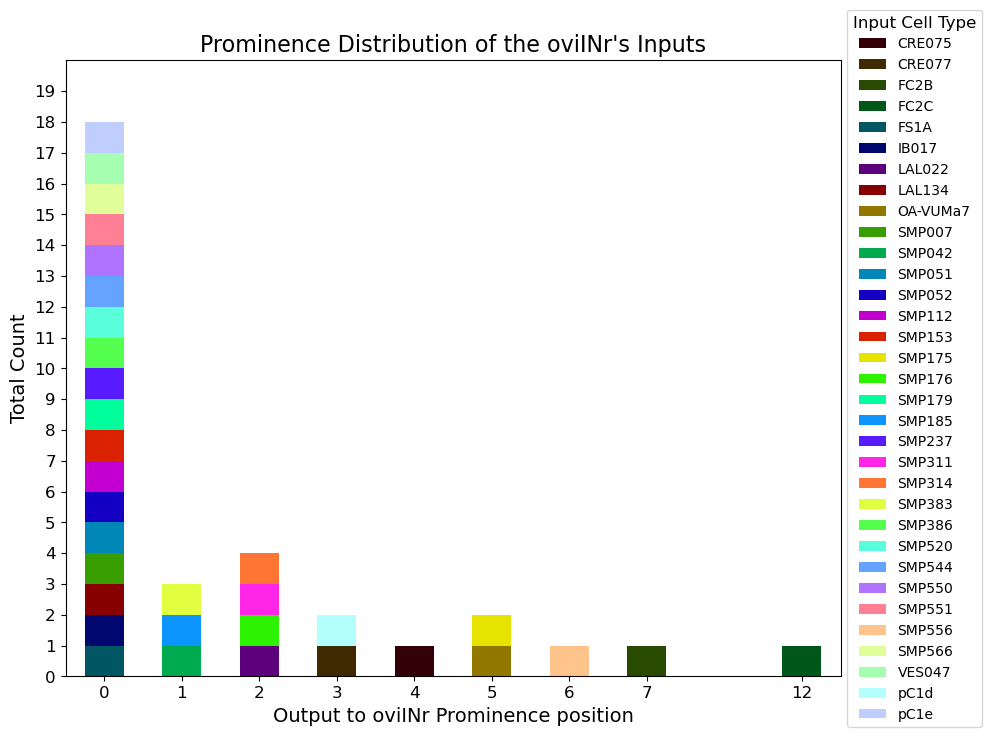

In [ ]:
fig, ax = plt.subplots(figsize=(10, 8))
# stacked bar plot
testchunk_pivot.plot(kind='bar', stacked=True, ax=ax, color= generate_colormap(len(testchunk_pivot.columns)))

# generate labels for each stacked bar using the cell type names
labels = testchunk_pivot.columns
# legend on the right of plot
ax.legend(loc='center left', bbox_to_anchor=(1, 0.5), title='Input Cell Type', title_fontsize='large', fontsize='medium')
plt.xticks(rotation=0,fontsize=12)
# yticks should be 19 of them evenly spaced
ax.set_yticks(np.linspace(0, 19, 20))
ax.set_yticklabels(np.linspace(0, 19, 20, dtype=int), fontsize=12)
ax.set_ylabel('Total Count', fontsize=14)
ax.set_xlabel('Output to oviINr Prominence position', fontsize=14)
ax.set_title("Prominence Distribution of the oviINr's Inputs", fontsize=16)
xticks = ax.xaxis.get_major_ticks()
xticks[8].set_visible(False)
plt.ylim(0, 20)


In [ ]:
# Create the upstream rings figure for figure 3B

# find ovi_inputs_new has any None
ovi_inputs_new = ovi_inputs_new.dropna()

ovi_inputs_new

,type_pre,weight
0,FS1A,892
1,IB017,370
2,SMP052,361
3,SMP176,299
4,FC2B,290
...,...,...
963,CRE060,1
964,CRE059,1
965,SMP412,1
966,CRE052,1


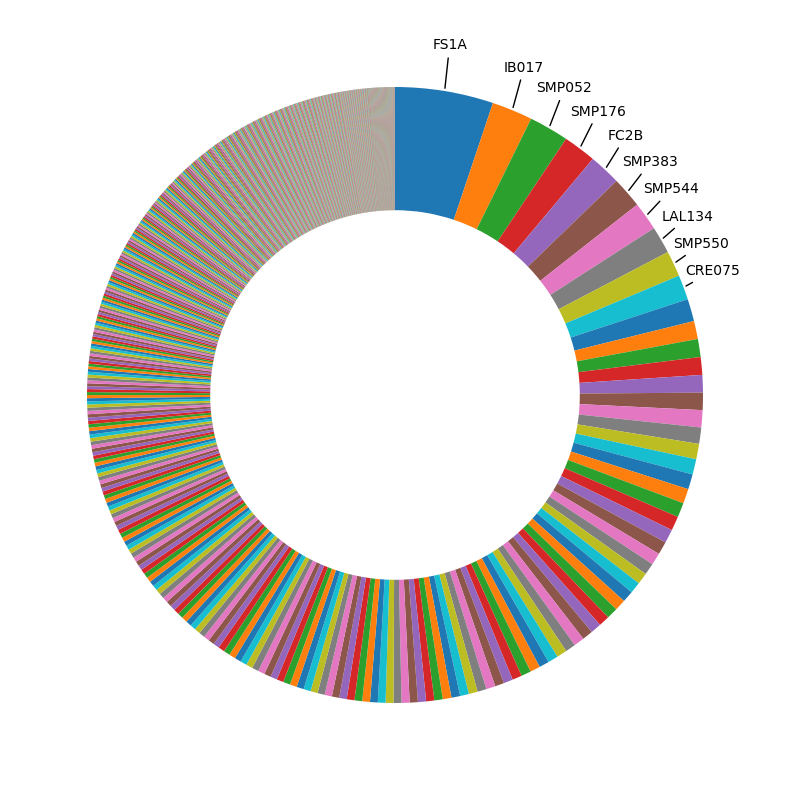

In [ ]:
fig, ax = plt.subplots(figsize=(10, 10))

# Plot the concentric ring but i want to only label the top 10
wedges, labels = ax.pie(ovi_inputs_new['weight'], startangle=90, counterclock=False, wedgeprops=dict(width=0.4))

# label only the top 10 wedges with simple text and a small line from the wedge to the label
for i in range(10):
    ang = (wedges[i].theta2 + wedges[i].theta1) / 2
    y = np.sin(np.deg2rad(ang))
    x = np.cos(np.deg2rad(ang))
    ax.annotate(ovi_inputs_new['type_pre'][i], xy=(x, y), xytext=(1.1*x, 1.15*y),
                fontsize=10, ha='center', va='center', color='black',
                arrowprops=dict(arrowstyle='-', color='black', lw=1))
